# Course 2 Project: ML Pipeline for Feature Engineering

## Instructions

In this project, you'll use data related to microeconomic indicators and historical stock prices to explore the data engineering pipline. You'll get to practice:

* Data ingestion 
* Data cleaning
* Data imputation
* Exploratory data analysis (EDA) through charts and graphs

## Packages

You'll use `pandas` and `matplotlib`, which were covered in the course material, to import, clean, and plot data. They have been installed in this workspace for you. If you're working locally and you installed Jupyter using Anaconda, these packages will already be installed. 

In [3]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 52.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 18.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 37.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import DateOffset

## Load data

The first step in a data engineering pipeline for machine learning is to ingest the data that will be used. For this project, data is hosted on a public GitHub repo. 

Your tasks:
* Import data from the provided GitHub repo using `pandas`
* Verify that the data has been imported correctly into `pandas` dataframes. Use methods like `head()` and `info()`
* You may need to change column names to make them easier to work with
* You may need to cast datetime data to the `datetime` format using `pandas` `to_datetime()` method

Data files to import: 
1. GDP
2. Inflation 
3. Apple stock prices 
4. Microsoft stock prices

In [5]:
# Load historical GDP data
gdp_df = pd.read_csv('GDP.csv', parse_dates=['DATE'])
gdp_df.columns = [col_name.lower() for col_name in gdp_df.columns]
gdp_df.set_index('date', inplace=True)

# Load historical inflation data
inflation_df = pd.read_csv('inflation_monthly.csv', parse_dates=['DATE'])
inflation_df.columns = ['date', 'inflation']
inflation_df.set_index('date', inplace=True)

In [6]:
# Check the first few rows of data
print("GDP Data")
print(gdp_df.head())
print()
print("Inflation Data")
print(inflation_df.head())

GDP Data
                gdp
date               
1947-01-01  243.164
1947-04-01  245.968
1947-07-01  249.585
1947-10-01  259.745
1948-01-01  265.742

Inflation Data
            inflation
date                 
1968-01-01   3.651861
1968-02-01   3.673819
1968-03-01   4.142164
1968-04-01   4.155828
1968-05-01   4.088245


In [7]:
# Load the historical stock price data for Apple and Microsoft
columns = ['date', 'close','volume','open', 'high', 'low']
# Load microsoft data
microsoft_df = pd.read_csv('microsoft_historical_data.csv', parse_dates=['Date'])
microsoft_df.columns = columns
microsoft_df.set_index('date', inplace=True)
microsoft_df.sort_index(ascending=True, inplace=True)
print(microsoft_df.head())

# Load apple data
apple_df = pd.read_csv('apple_historical_data.csv', parse_dates=['Date'])
apple_df.columns = columns
apple_df.set_index('date', inplace=True)
apple_df.sort_index(ascending=True, inplace=True)
print(apple_df.head())

              close    volume    open    high     low
date                                                 
2014-05-06   $39.06  27105700  $39.29  $39.35  $38.95
2014-05-07  $39.425  41731030  $39.22  $39.51  $38.51
2014-05-08   $39.64  32089010  $39.34  $39.90  $38.97
2014-05-09   $39.54  29646100  $39.54  $39.85  $39.37
2014-05-12   $39.97  22761620  $39.74  $40.02  $39.65
              close     volume     open     high      low
date                                                     
2014-05-06  $21.23   373872650  $21.49   $21.59   $21.23 
2014-05-07  $21.15   282128727  $21.26   $21.33   $20.99 
2014-05-08  $21.00   228973884  $21.01   $21.23   $20.94 
2014-05-09  $20.91   291068564  $20.88   $20.94   $20.73 
2014-05-12  $21.17   212736019  $20.98   $21.20   $20.98 


In [8]:
# Check the first few rows of data
print('Microsoft Data',)
print(microsoft_df.head())
print()
print('Apple Data')
print(apple_df.head())

Microsoft Data
              close    volume    open    high     low
date                                                 
2014-05-06   $39.06  27105700  $39.29  $39.35  $38.95
2014-05-07  $39.425  41731030  $39.22  $39.51  $38.51
2014-05-08   $39.64  32089010  $39.34  $39.90  $38.97
2014-05-09   $39.54  29646100  $39.54  $39.85  $39.37
2014-05-12   $39.97  22761620  $39.74  $40.02  $39.65

Apple Data
              close     volume     open     high      low
date                                                     
2014-05-06  $21.23   373872650  $21.49   $21.59   $21.23 
2014-05-07  $21.15   282128727  $21.26   $21.33   $20.99 
2014-05-08  $21.00   228973884  $21.01   $21.23   $20.94 
2014-05-09  $20.91   291068564  $20.88   $20.94   $20.73 
2014-05-12  $21.17   212736019  $20.98   $21.20   $20.98 


In [9]:
# Use methods like .info() and .describe() to explore the data
print(gdp_df.info())
print(gdp_df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309 entries, 1947-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gdp     309 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
None
                gdp
count    309.000000
mean    7227.754935
std     7478.297734
min      243.164000
25%      804.981000
50%     4386.773000
75%    12527.214000
max    28284.498000


In [10]:
print(inflation_df.info())
print("\n",inflation_df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 675 entries, 1968-01-01 to 2024-03-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inflation  675 non-null    float64
dtypes: float64(1)
memory usage: 10.5 KB
None

         inflation
count  675.000000
mean     4.331276
std      2.694022
min      0.663868
25%      2.453373
50%      3.354398
75%      5.202000
max     15.774167


## Data preprocessing: Check for missing data and forward fill

Check the Apple historical prices for missing data. Check for missing data in all columns. If there's data missing, use a forward fill to fill in those missing prices. 

In [11]:
# Check for nulls 
print("Apple Info")
print(apple_df.info())
print("\nCheck for NaN")
print(apple_df.isna().sum())

Apple Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-05-06 to 2024-05-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   close   2514 non-null   object
 1   volume  2517 non-null   int64 
 2   open    2517 non-null   object
 3   high    2517 non-null   object
 4   low     2517 non-null   object
dtypes: int64(1), object(4)
memory usage: 118.0+ KB
None

Check for NaN
close     3
volume    0
open      0
high      0
low       0
dtype: int64


In [12]:
# Forward fill any missing data
apple_df.ffill(inplace=True)

In [13]:
# Check again for nulls after using forward fill
print("\nCheck for NaN")
print(apple_df.isna().sum())


Check for NaN
close     0
volume    0
open      0
high      0
low       0
dtype: int64


## Data preprocessing: Remove special characters and convert to numeric/datetime

The next step in the data engineering process is to standardize and clean up data. In this step, you'll check for odd formatting and special characters that will make it difficult to work with data as numeric or datetime. 

In this step:
* Create a function that takes in a dataframe and a list of columns and removes dollar signs ('$') from those columns
* Convert any columns with date/time data into a `pandas` `datetime` format

In [14]:
def convert_dollar_columns_to_numeric(df, numeric_columns):
    '''
        Removes dollar signs ('$') from a list of columns in a given dataframe AND casts the columns to a numeric datatype.
        Updates dataframe IN PLACE.
        
        Inputs:
            df: dataframe to be operated on
            numeric_columns: columns that should have numeric data but have dollar signs currently
            
        Returns:
            None - changes to the dataframe can be made in place
    '''
    _df = df.copy()
    for column in numeric_columns:
        try:
            _df[column] = _df[column].str.replace('$', '').astype(float)
        except AttributeError as e:
            print("Column '" + column + "' is not a string!")
            print(e)
    return _df 

In [15]:
# Use convert_dollar_columns_to_numeric() to remove the dollar sign from the Apple and Microsoft datasets
numeric_columns = ['close', 'open', 'high', 'low']
apple_df = convert_dollar_columns_to_numeric(apple_df, numeric_columns)
microsoft_df = convert_dollar_columns_to_numeric(microsoft_df, numeric_columns)

In [16]:
# Use pandas's to_datetime() to convert any columns that are in a datetime format



In [17]:
# Use .info() and check the type of each column to ensure that the above steps worked
print("Apple Info")
print(apple_df.info())
print("\nMicrosft Info")
print(microsoft_df.info())


Apple Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-05-06 to 2024-05-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2517 non-null   float64
 1   volume  2517 non-null   int64  
 2   open    2517 non-null   float64
 3   high    2517 non-null   float64
 4   low     2517 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 118.0 KB
None

Microsft Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-05-06 to 2024-05-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2517 non-null   float64
 1   volume  2517 non-null   int64  
 2   open    2517 non-null   float64
 3   high    2517 non-null   float64
 4   low     2517 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 118.0 KB
None


## Data preprocessing: Align datetime data

Data engineering includes changing data with a datetime component if needed so that different time series can be more easily compared or plotted against each other. 

In this step:

* Align the inflation date so that it falls on the last day of the month instead of the first

Helpful hints: 
* Use the `pandas` `offsets` method using `MonthEnd(0)` to set the 'Date' column to month-end

In [18]:
# Align inflation data so that the date is the month end (e.g. Jan 31, Feb 28/28)
inflation_df.reset_index(inplace=True)
inflation_df['date'] = inflation_df['date'].apply(lambda x: pd.offsets.MonthEnd().rollforward(x))
inflation_df.set_index('date', inplace=True, drop=True)
print(inflation_df.head())
print(inflation_df.tail())

            inflation
date                 
1968-01-31   3.651861
1968-02-29   3.673819
1968-03-31   4.142164
1968-04-30   4.155828
1968-05-31   4.088245
            inflation
date                 
2023-11-30   4.688293
2023-12-31   4.554396
2024-01-31   4.603922
2024-02-29   4.403102
2024-03-31   4.509212


## Data preprocessing: Upsample, downsample and interpolate data

Inflation data is presented monthly in this dataset. However, for some models, you may need it at a quarterly frequency, and for some models you may need it at a quarterly frequency. 

In this step:
* Create a new quarterly inflation dataframe by downsampling the monthly inflation data to quarterly using the mean (e.g. for quarter 1 in a given year, use the average values from January, February, and March)
* Create a new weekly inflation dataframe by upsampling the monthly inflation data. For this, you'll need to use `resample` and then you'll need to `interpolate` to fill in the missing data at the weekly frequency

Note that you may need to change the index for some of these operations! 

,inflation
date,
1968-03-31,4.142164
1968-04-07,4.171434
1968-04-14,4.200997
1968-04-21,4.230853
1968-04-28,4.261004
...,...
2024-03-03,4.471039
2024-03-10,4.476243
2024-03-17,4.484340


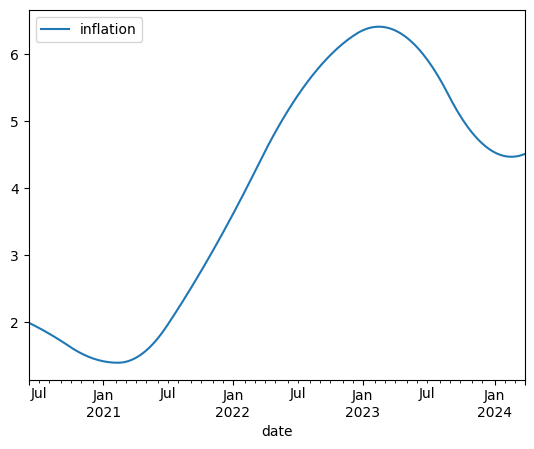

In [19]:
# Upsample and interpolate from monthly to weekly 
weekly_inflation_df = inflation_df.resample('W').interpolate(method='polynomial', order=2).dropna()
weekly_inflation_df.iloc[-200:].plot()
weekly_inflation_df

,inflation
date,
1968-03-31,3.822615
1968-06-30,4.263214
1968-09-30,4.882643
1968-12-31,5.429443
1969-03-31,5.873770
...,...
2023-03-31,6.467833
2023-06-30,5.942054
2023-09-30,5.179249


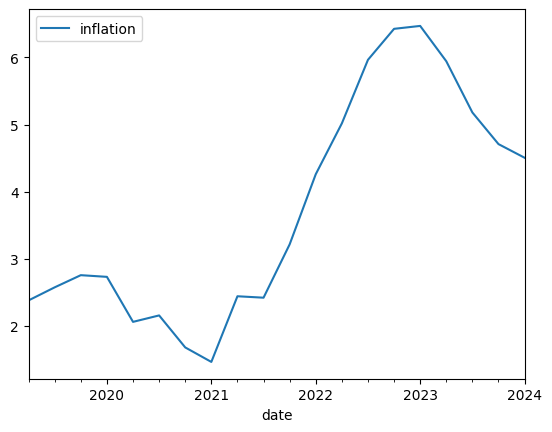

In [20]:
# Downsample from monthly to quarterly 
quarterly_inflation_df = inflation_df.resample('QE').mean()
quarterly_inflation_df.iloc[-20:].plot()
quarterly_inflation_df

## Data preprocessing: Normalize/standardize a feature

Economic time series data often involve variables measured on different scales (e.g., GDP in trillions of dollars, inflation in percentage points). Standardizing these variables (typically by subtracting the mean and dividing by the standard deviation) puts them on a common scale, allowing for meaningful comparisons and analyses.

Your task:
* Standardize the GDP data. You may do this manually by subtracting the mean and dividing by the standard deviation, or you may use a built-in method from a library like `sklearn`'s `StandardScaler`

In [21]:
# Standardize the GDP measure
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
gdp_scaled = gdp_df.copy()
gdp_scaled['gdp'] = scaler.fit_transform(gdp_df.gdp.values.reshape(-1,1))
print(gdp_scaled.head())
print(gdp_scaled.tail())


                 gdp
date                
1947-01-01 -0.935496
1947-04-01 -0.935121
1947-07-01 -0.934636
1947-10-01 -0.933276
1948-01-01 -0.932472
                 gdp
date                
2023-01-01  2.623273
2023-04-01  2.656678
2023-07-01  2.729957
2023-10-01  2.776416
2024-01-01  2.820281


In [22]:
# Check the dataframe to make sure the calculation worked as expected 
gdp_scaled


,gdp
date,
1947-01-01,-0.935496
1947-04-01,-0.935121
1947-07-01,-0.934636
1947-10-01,-0.933276
1948-01-01,-0.932472
...,...
2023-01-01,2.623273
2023-04-01,2.656678
2023-07-01,2.729957


## EDA: Plotting a time series of adjusted open vs close price

As part of your EDA, you'll frequently want to plot two time series on the same graph and using the same axis to compare their movements. 

Your task:
* Plot the Apple open and close price time series on the same chart **for the last three months only**. Be sure to use a legend to label each line

**NOTE**: This is a large dataset. If you try to plot the entire series, your graph will be hard to interpret and may take a long time to plot. Be sure to use only the most recent three months of data. 

In [23]:
# Get max date in timeseries
max_date = apple_df.index.max()
max_date

Timestamp('2024-05-03 00:00:00')

In [24]:
# Use the max date calculated above to get the last three months of data in the dataset 
last_3_month_mask = apple_df.index > (max_date - DateOffset(months=3))
last_3_month_mask

array([False, False, False, ...,  True,  True,  True])

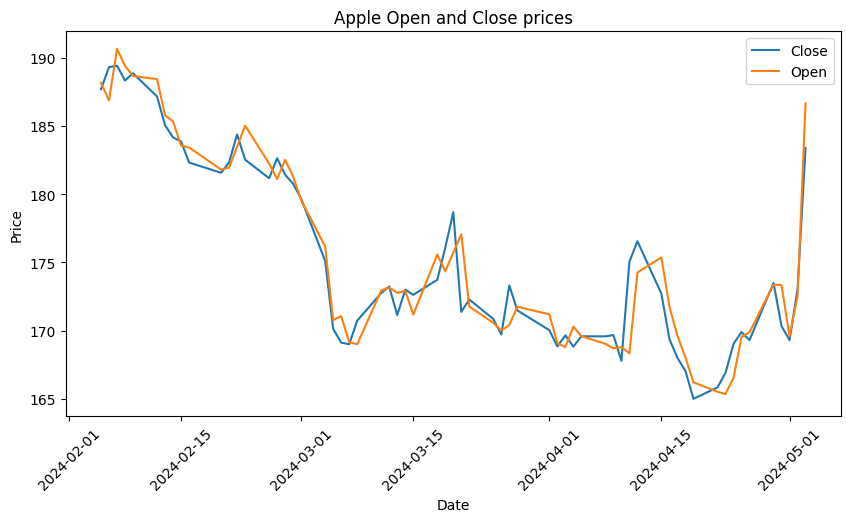

In [25]:
# Plot time series of open v. close stock price for Apple using the last 3 months of data
fig, ax = plt.subplots(figsize=(10,5))
apple_3_month_df = apple_df[last_3_month_mask]
ax.plot(apple_3_month_df.close)
ax.plot(apple_3_month_df.open)
ax.set_title('Apple Open and Close prices')
ax.set_xlabel("Date")
plt.xticks(rotation=45)
ax.set_ylabel('Price')
ax.legend(['Close', 'Open'])
plt.show()



## EDA: Plotting a histogram of a stock's closing price in the last three months

One way to see how much a stock's price generally moves is to plot the frequency of closing prices over a set time period. 

Your task:
* Use the **last three months** of Apple stock data and plot a histogram of closing price

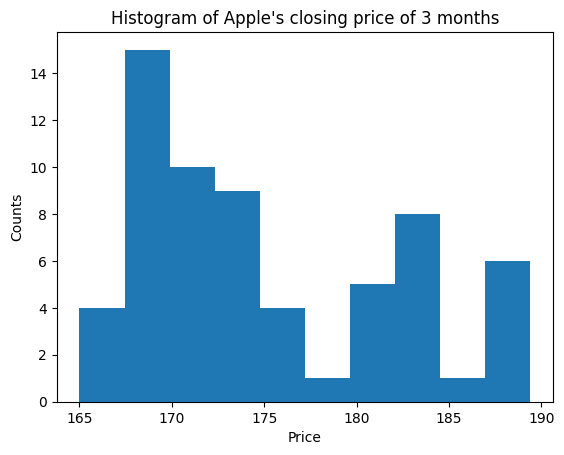

In [26]:
# Plot the histogram of Apple's closing price over the last 3 months 
plt.hist(apple_3_month_df.close)
plt.title("Histogram of Apple's closing price of 3 months")
plt.xlabel("Price")
plt.ylabel("Counts")
plt.show()


## Calculating correlation between a stock price and a macroeconomic variable 

Inflation affects the purchasing power of money and can influence corporate profits, interest rates, and consumer behavior. By analyzing the correlation between stock prices and inflation, one can gauge how inflationary trends impact stock market performance. For instance, high inflation might erode profit margins and reduce stock prices, while moderate inflation might indicate a growing economy, benefiting stocks.

Your task:
* Plot a heatmap that shows the correlation between Microsoft and Apple returns and inflation 

This will require several steps:
1. Calculate the returns for Apple and Microsoft and the change in monthly inflation (use the `pct_change` method for each)
2. Interpolate the daily stock returns data to monthly so it can be compared to the monthly inflation data
3. Merge the stock returns (Apple and Microsoft) and inflation data series into a single dataframe
4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change
5. Plot the correlation matrix as a heatmap

### 1. Calculate returns for Microsoft / Apple and the monthly change in inflation

In [27]:
# Calculate daily returns for Apple and Microsoft and the percent change in inflation from month to month
apple_returns = pd.DataFrame(apple_df.close.pct_change(), columns = ['close']).dropna()
microsoft_returns = pd.DataFrame(microsoft_df.close.pct_change(), columns = ['close']).dropna()
microsoft_returns


,close
date,
2014-05-07,0.009345
2014-05-08,0.005453
2014-05-09,-0.002523
2014-05-12,0.010875
2014-05-13,0.011258
...,...
2024-04-29,-0.010017
2024-04-30,-0.032119
2024-05-01,0.014409


### 2. Interpolate stock returns from daily to monthly

In [28]:
apple_monthly_returns = apple_df['close'].resample('ME').last().pct_change().dropna()
microsoft_monthly_returns = microsoft_df['close'].resample('ME').last().pct_change().dropna()
inflation_pct_change = inflation_df.pct_change().dropna()
microsoft_monthly_returns
inflation_pct_change.head()

,inflation
date,
1968-02-29,0.006013
1968-03-31,0.127482
1968-04-30,0.003299
1968-05-31,-0.016262
1968-06-30,0.111863


### 3. Merge the dataframes and calculate / plot the correlation

In [29]:
stocks = pd.merge(apple_monthly_returns, microsoft_monthly_returns, left_index=True, right_index=True, how='inner')
stocks.columns = ['apple', 'microsoft']
stocks_and_inflation = pd.merge(stocks, inflation_pct_change, left_index=True, right_index=True, how='inner')
stocks_and_inflation.head()

,apple,microsoft,inflation
date,,,
2014-06-30,0.027421,0.018564,0.007147
2014-07-31,0.028842,0.035012,-0.020724
2014-08-31,0.072385,0.052595,-0.066387
2014-09-30,-0.017167,0.020471,-0.004516
2014-10-31,0.071854,0.012726,0.026302


### 4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change

In [30]:
# Calculate correlation matrix
stocks_and_inflation_corr = stocks_and_inflation.corr()

### 5. Plot the correlation matrix as a heatmap 

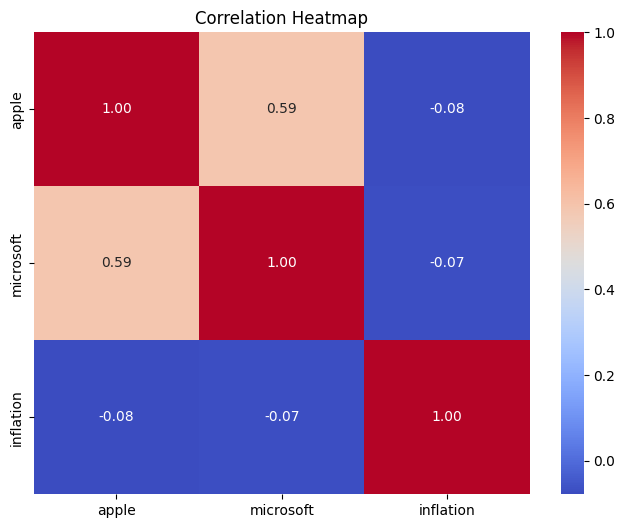

In [31]:
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(stocks_and_inflation_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

## Calculating rolling volatility (standard deviation) of a stock's price for last 3 months

Volatility is a measure of the dispersion of returns for a given security. By calculating rolling volatility, investors can assess the risk associated with a stock over time: Higher volatility indicates higher risk, as the stock's price is more likely to experience significant fluctuations. In portfolio optimization, understanding the volatility of individual stocks and how it changes over time is crucial for diversification and optimization. By analyzing rolling volatility, investors can adjust their portfolios to maintain a desired risk level, potentially improving the risk-return profile.

One possible way to calculate volatility is by using the standard deviation of returns for a stock over time.

Your task:
* Calculate the weekly rolling standard deviation for Apple's closing price
* Plot the calculated rolling weekly volatility of Apple's closing price against Apple's closing price. Plot these **on the same chart, but using different y-axes**

Helpful hints:
* You'll need to use the `pandas` `rolling()` method with a given `window_size` parameter to make it a _weekly_ rolling calculation
* Use **only the last three months of data**; data much older than this may not be as useful for portfolio optimization
* You'll need to create two axes on the matplotlib figure to be able to use two different y-axes (one for the closing price and one for the rolling volatility calculated here)

In [32]:
# Define the window size for the rolling calculation (e.g., one week)
dates = apple_df.index
max_date = dates.max()
date_mask = dates > (max_date - DateOffset(months=3))
apple_3_month_df = apple_df[date_mask].copy()

In [33]:
# Calculate rolling one-week volatility
apple_3_month_df.loc[:,'1_week_std'] = apple_3_month_df['close'].rolling(window=5).std()
apple_3_month_df

,close,volume,open,high,low,1_week_std
date,,,,,,
2024-02-05,187.68,69668820,188.15,189.25,185.84,NaN
2024-02-06,189.30,43490760,186.86,189.31,186.77,NaN
2024-02-07,189.41,53438960,190.64,191.05,188.61,NaN
2024-02-08,188.32,40962050,189.39,189.54,187.35,NaN
2024-02-09,188.85,45155220,188.65,189.99,188.00,0.719493
...,...,...,...,...,...,...
2024-04-29,173.50,68169420,173.37,176.03,173.10,2.394581
2024-04-30,170.33,65934780,173.33,174.99,170.00,1.802018
2024-05-01,169.30,50383150,169.58,172.71,169.11,1.751751


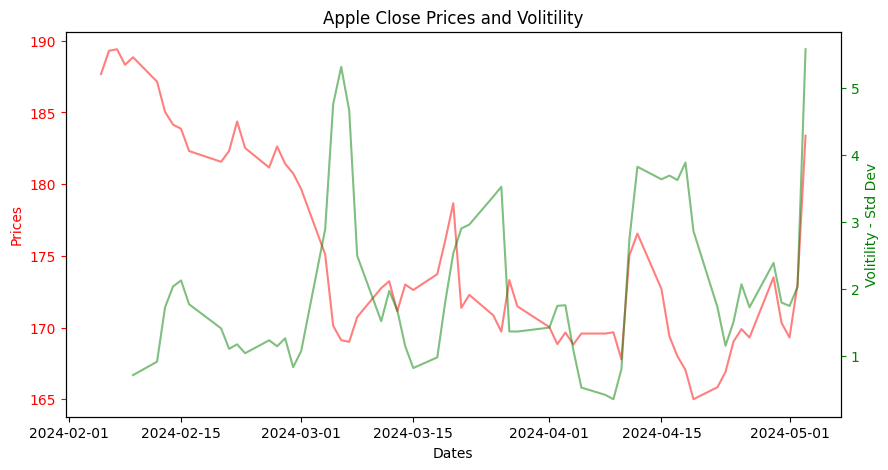

In [101]:
# Plot the calculated rolling weekly volatility of Apple's closing price against Apple's closing price
# Plot these on the same chart, but using different y-axes
fig, ax1 = plt.subplots(figsize = (10, 5))
ax2 = ax1.twinx()

ax1.plot(apple_3_month_df.close, 'r', alpha=0.5)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Prices', color='r')
ax1.tick_params(axis='y', colors='r')

ax2.plot(apple_3_month_df['1_week_std'], 'g', alpha=0.5)
ax2.set_ylabel('Volitility - Std Dev', color='g')
ax2.tick_params(axis='y', colors="g")

plt.xticks(rotation=45)
plt.title('Apple Close Prices and Volitility')
plt.show()



## Export data

Now that you have preprocessed your data, you should save it in new csv files so that it can be used in downstream tasks without having to redo all the preprocessing steps. 

Your task:
* Use `pandas` to export all modified datasets back to new CSV files

In [100]:
apple_df.to_csv('apple_prices_clean.csv')
apple_monthly_returns.to_csv('apple_returns.csv')

microsoft_df.to_csv('microsoft_prices_clean.csv')
microsoft_returns.to_csv('microsoft_returns_clean.csv')

inflation_df.to_csv('inflation_data_clean.csv')
gdp_df.to_csv('gdp_data_clean.csv')